In [1]:
import torch
from torch.optim import Optimizer
from sklearn import datasets
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_boston(ratio=0.8):
    X, Y = datasets.load_boston(True)
    Y.shape = -1, 1
    
    # normalization
    X = X/80
    Y = Y/(np.max(Y) - np.min(Y))
    
    num_samples = len(Y)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = X[idx[:num_train]], Y[idx[:num_train]]
    validdata = X[idx[num_train:]], Y[idx[num_train:]]
    
    return traindata, validdata

In [3]:
class GradientDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.9):
        # 将参数导回Optimizer，这样可以允许lr_scheduler修改lr
        defaults = dict(lr=lr, alpha=alpha)
        super().__init__(params, defaults)
        self.v=[]
        for group in self.param_groups:
            for p in group['params']:
                self.v.append(0)
        
        
    def step(self):
        k=0
        for group in self.param_groups:
            alpha = group['alpha']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    k=k+1
                    continue
                grad = p.grad.data
                self.v[k]=alpha*self.v[k]-lr*grad
                p.data=p.data+self.v[k]
                k=k+1
                
                

            

In [4]:
(X_train, Y_train), (X_valid, Y_valid) = load_boston()
X_train, Y_train = torch.Tensor(X_train), torch.Tensor(Y_train)
X_valid, Y_valid = torch.Tensor(X_valid), torch.Tensor(Y_valid)

In [5]:
model = torch.nn.Sequential(
    torch.nn.Linear(13, 50),
    torch.nn.Sigmoid(),
    torch.nn.Linear(50, 1)
)

In [6]:
loss = torch.nn.MSELoss()

In [7]:
opt = GradientDescent(model.parameters(), lr=1e-5,alpha=0.99)

In [8]:
valid_losses = []
train_losses = []
for i in range(1000):
    X, Y = X_train, Y_train
    
    opt.zero_grad()
    l = loss(model(X), Y)
    l.backward()
    opt.step()
    
    with torch.no_grad():
        cur_train_loss = l
        cur_valid_loss = loss(Y_valid, model(X_valid))
        valid_losses.append(cur_valid_loss) 
        train_losses.append(cur_train_loss)

        if i%100 == 0:
            print(f"Iter {i}: loss {cur_train_loss:.4f}, valid loss {cur_valid_loss:.4f}")
       

Iter 0: loss 0.2703, valid loss 0.2773
Iter 100: loss 0.0479, valid loss 0.0605
Iter 200: loss 0.0725, valid loss 0.0886
Iter 300: loss 0.0398, valid loss 0.0538
Iter 400: loss 0.0426, valid loss 0.0557
Iter 500: loss 0.0370, valid loss 0.0504
Iter 600: loss 0.0366, valid loss 0.0497
Iter 700: loss 0.0351, valid loss 0.0480
Iter 800: loss 0.0343, valid loss 0.0471
Iter 900: loss 0.0335, valid loss 0.0461


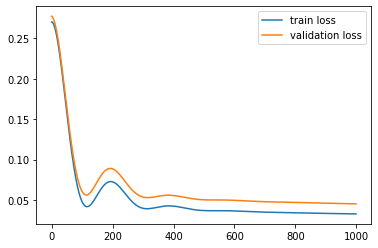

In [9]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])